# Hello Deep Convolutional GAN for generating for FMNIST style images

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("TensorFlow Version: ", tf.__version__)

2025-04-01 15:42:58.782255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743547378.800866 2417240 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743547378.806838 2417240 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743547378.821982 2417240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743547378.821999 2417240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743547378.822001 2417240 computation_placer.cc:177] computation placer alr

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Numpy Version:  2.1.3
Pandas Version:  2.2.3
TensorFlow Version:  2.19.0


The latest TensorFlow is based on Keras 3. Not everything needed for this sample is implemented in Keras 3, so need to revert back to Keras 2.  To use Keras 2.*, do the following:

- Import the `tf_keras` package.
- Set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` 

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

import tf_keras
print("tf_keras version:", tf_keras.__version__)


tf_keras version: 2.19.0


Check for GPU presence

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU detected")
else:
    print("No GPU Detected")

GPU detected


### Get Fashion MNIST Dataset

In [4]:
# Get dataset and split into training, validation, and test sets
f_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = f_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

### Define GAN generator and discrimator

In [5]:
tf.random.set_seed(42)

codings_size = 100

gan_generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])
gan_discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([gan_generator, gan_discriminator])

I0000 00:00:1743547512.739013 2417240 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9225 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


#### Compile 

Generator will be trained only thru the GAN model, so need to compile it.  Discriminator should not be trined during the second phase of training, so set discriminator trainable to false for GAN model

In [6]:
gan_discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
gan_discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

#### Custom Training Loop

In [7]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

Create a dataset to iterate over images

In [8]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Training Loop

Helper function to visualize images

In [9]:
def viz_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [13]:
def train_gan(gan, dataset, batch_size, codings_size, nr_epochs):
    generator, discriminator = gan.layers
    for epoch in range(nr_epochs):
        print(f"Epoch {epoch + 1}/{nr_epochs}")
        for X_batch in dataset:
            # phase 1: train the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2: train the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # Vizualize images during training
        viz_multiple_images(generated_images.numpy(), 8)
        plt.show()

Epoch 1/50


I0000 00:00:1743547685.471003 2417240 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1743547686.105676 2417240 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1743547687.087481 2417373 service.cc:152] XLA service 0x74e022749100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743547687.087501 2417373 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-04-01 15:48:07.093063: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743547687.165941 2417373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-01 15:48:42.820878: I tensorflow/core/

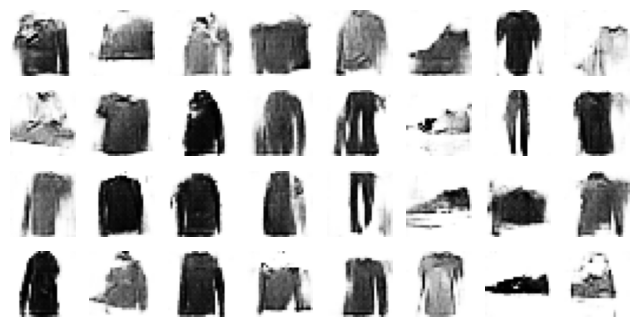

Epoch 2/50


2025-04-01 15:49:17.465934: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


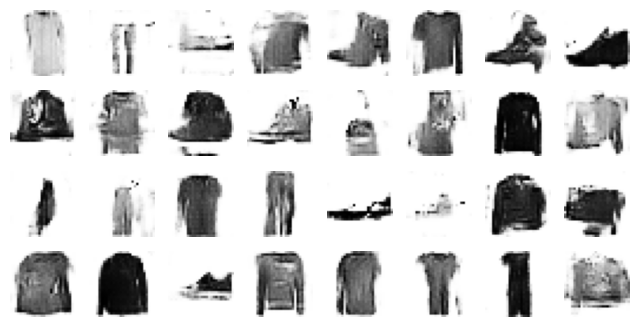

Epoch 3/50


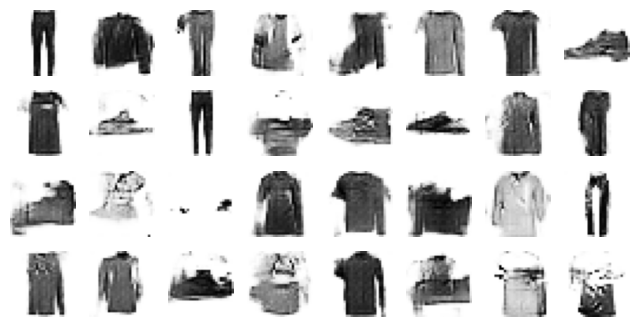

Epoch 4/50


2025-04-01 15:50:25.566463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


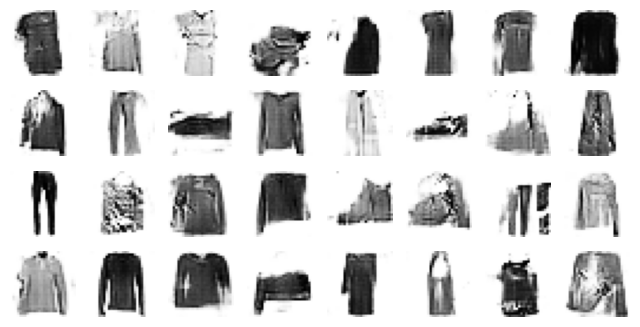

Epoch 5/50


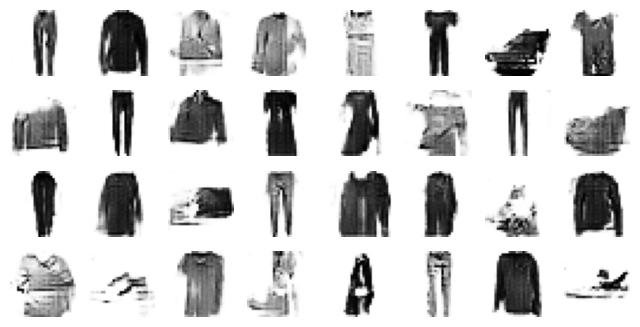

Epoch 6/50


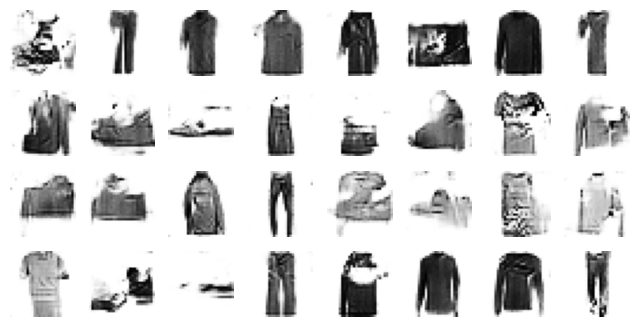

Epoch 7/50


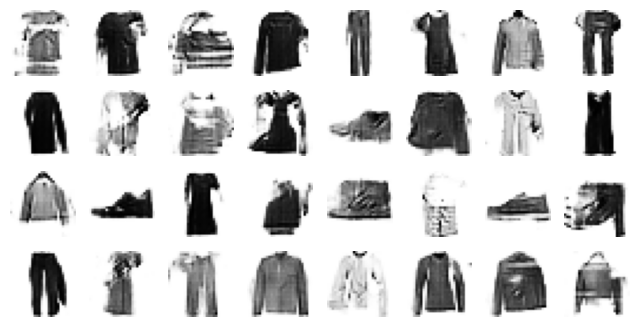

Epoch 8/50


2025-04-01 15:52:42.208557: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


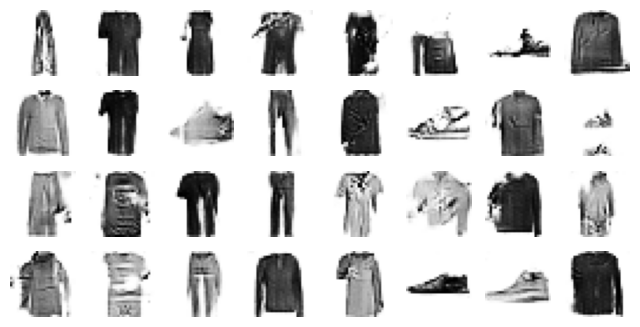

Epoch 9/50


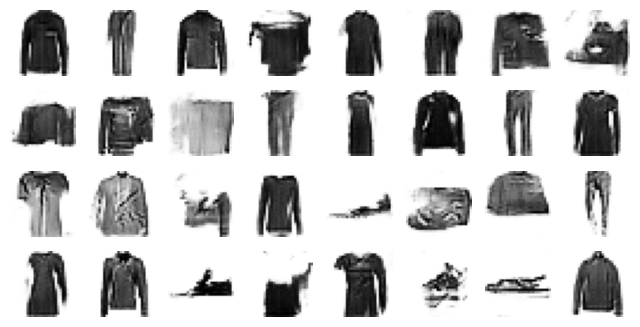

Epoch 10/50


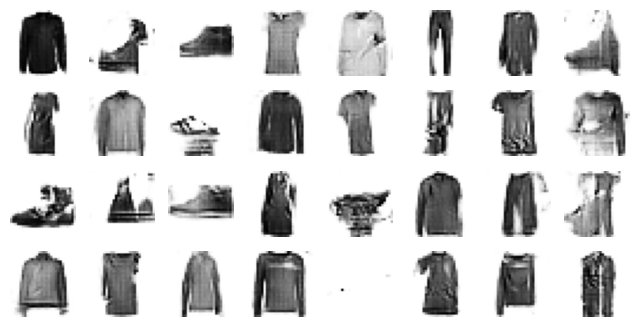

Epoch 11/50


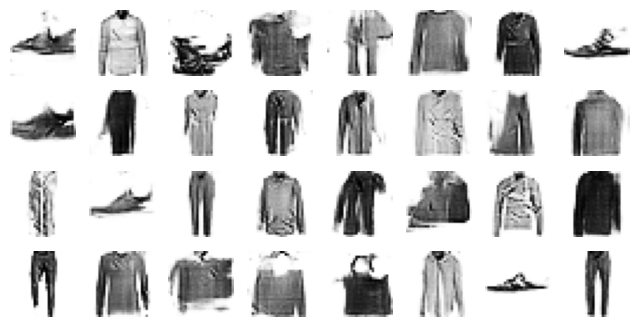

Epoch 12/50


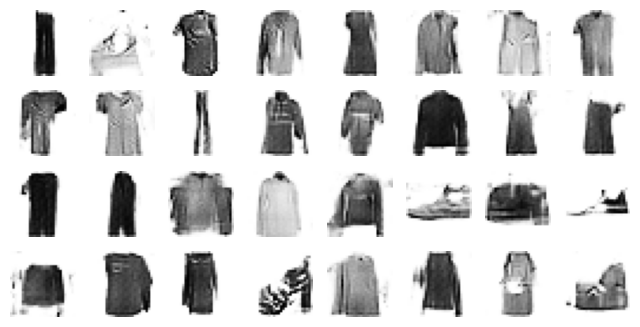

Epoch 13/50


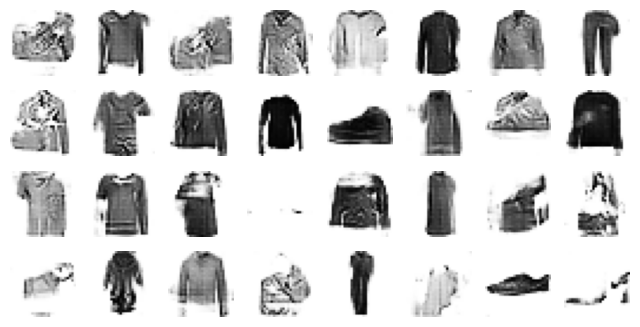

Epoch 14/50


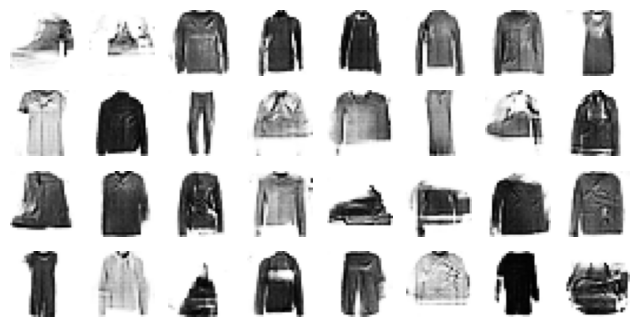

Epoch 15/50


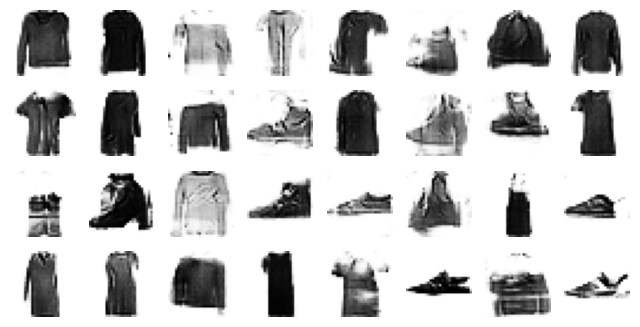

Epoch 16/50


2025-04-01 15:57:15.349568: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


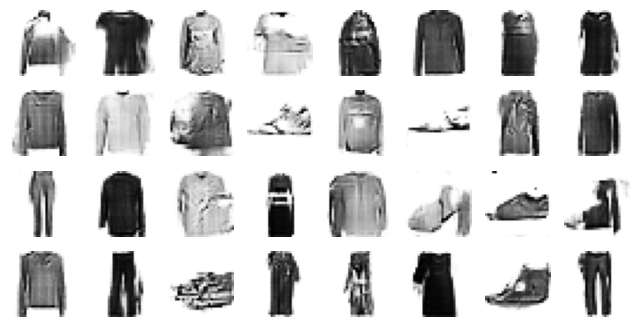

Epoch 17/50


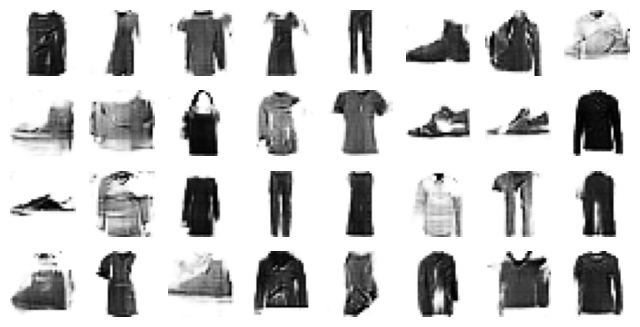

Epoch 18/50


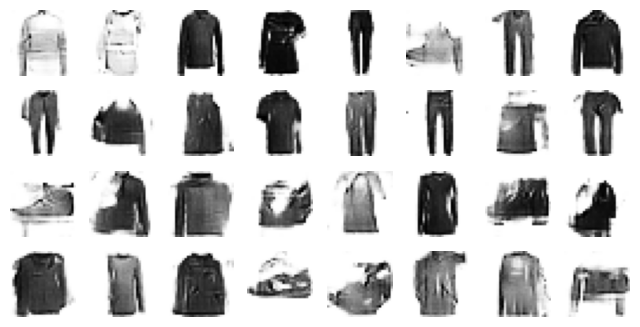

Epoch 19/50


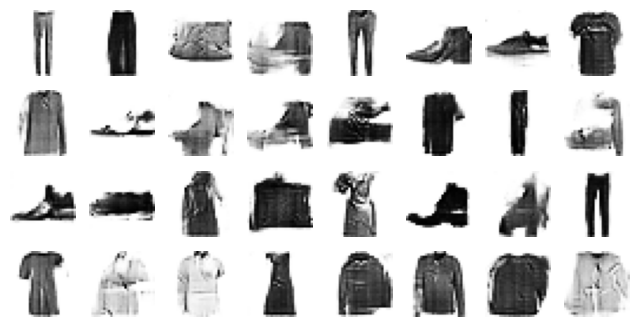

Epoch 20/50


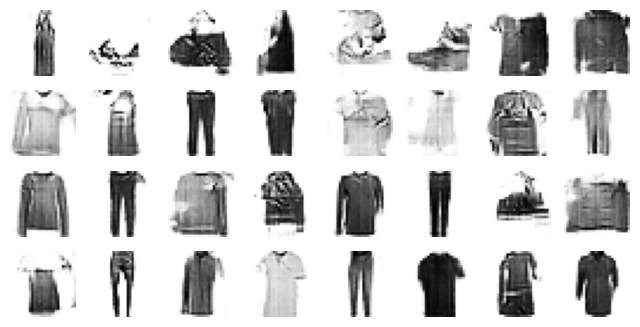

Epoch 21/50


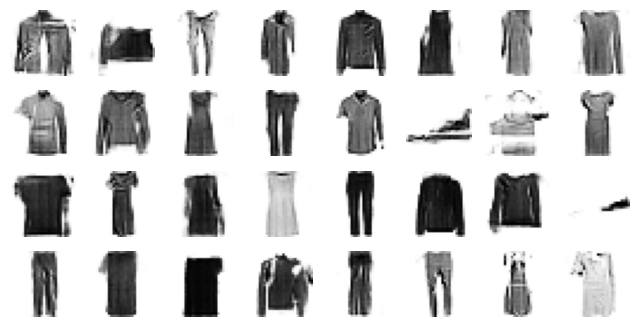

Epoch 22/50


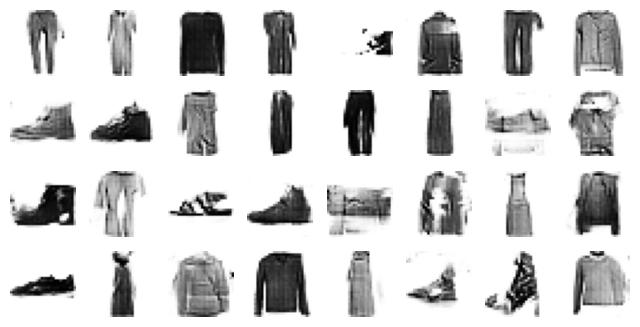

Epoch 23/50


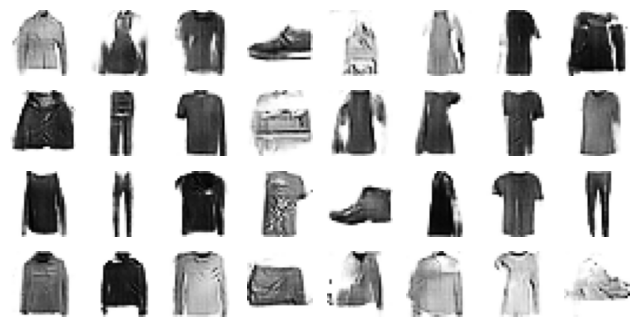

Epoch 24/50


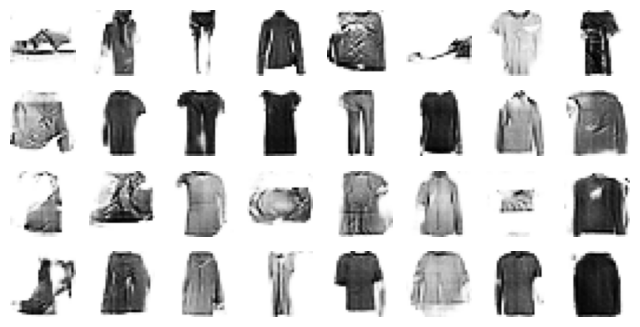

Epoch 25/50


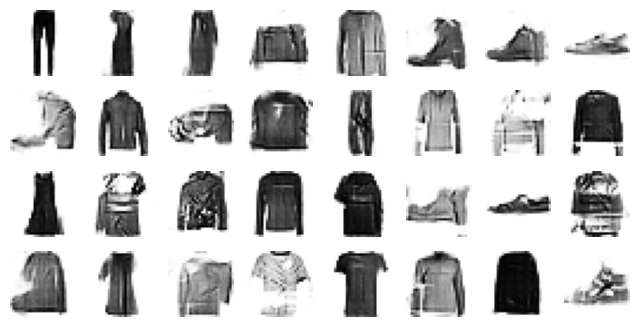

Epoch 26/50


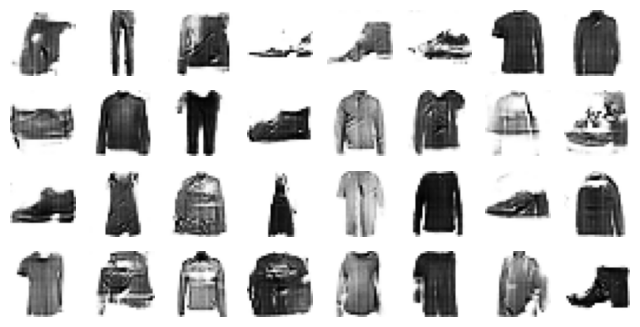

Epoch 27/50


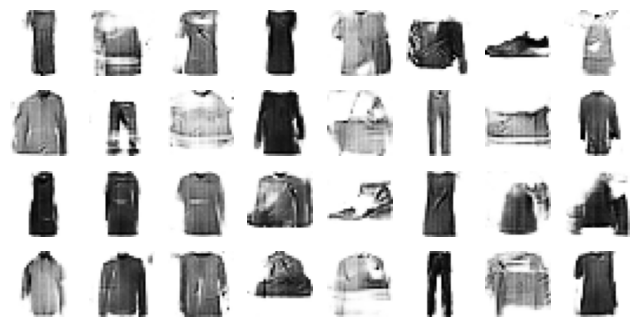

Epoch 28/50


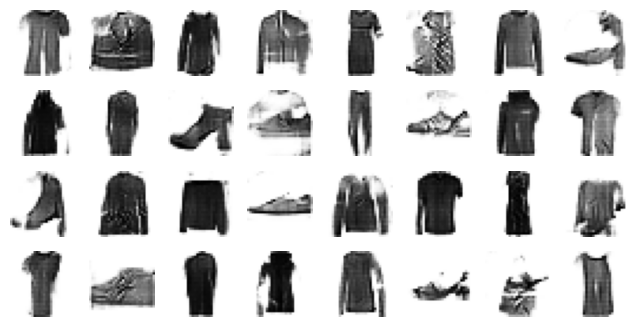

Epoch 29/50


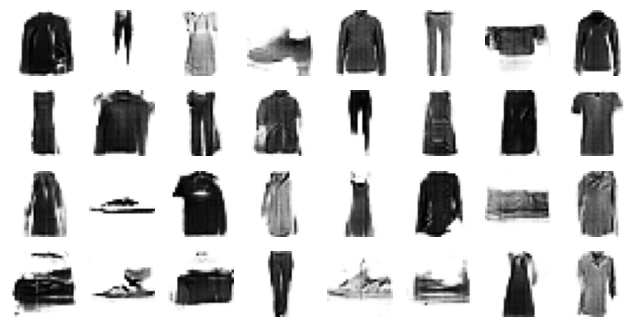

Epoch 30/50


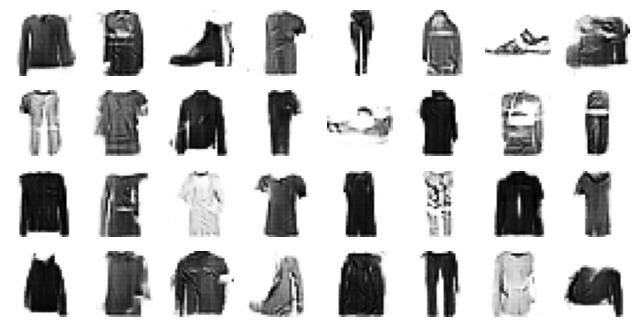

Epoch 31/50


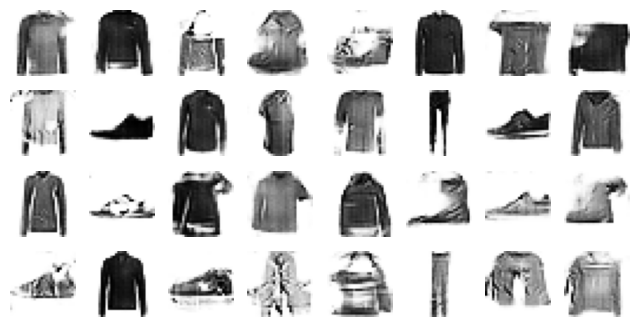

Epoch 32/50


2025-04-01 16:06:14.672975: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


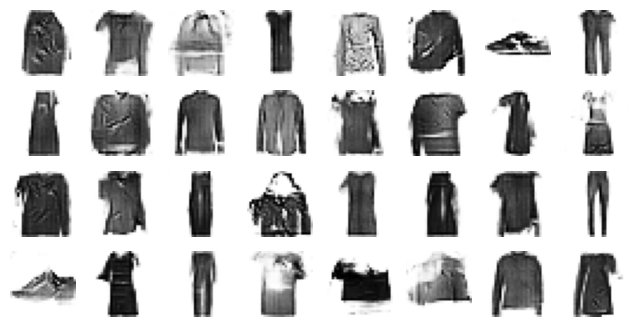

Epoch 33/50


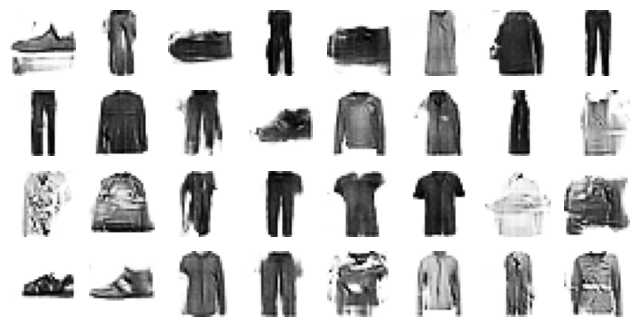

Epoch 34/50


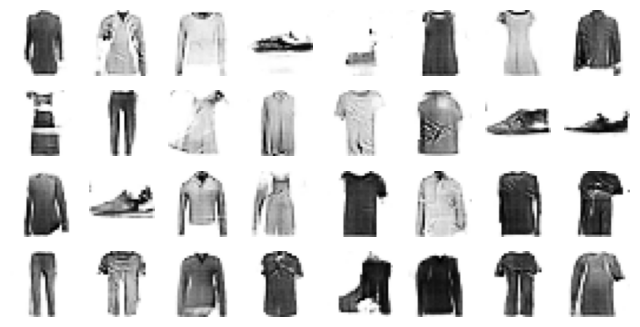

Epoch 35/50


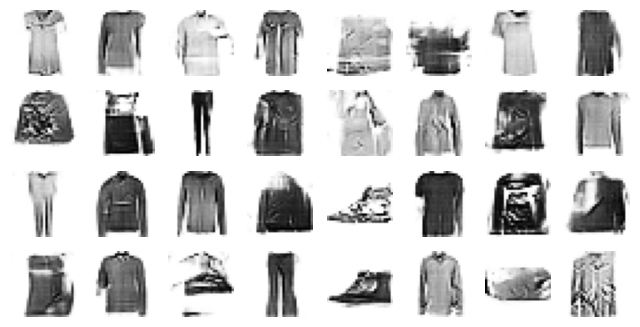

Epoch 36/50


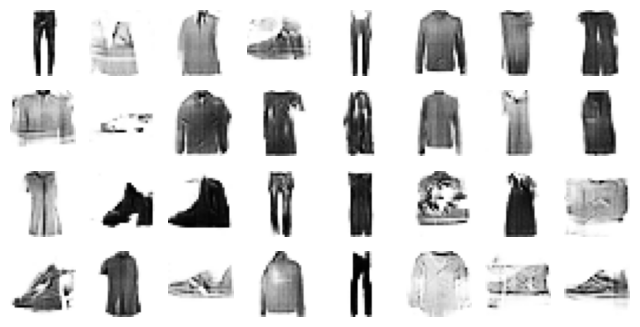

Epoch 37/50


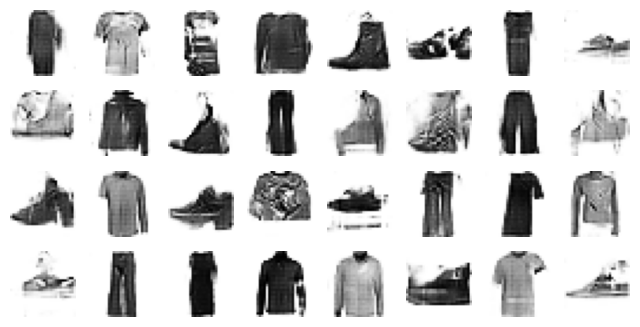

Epoch 38/50


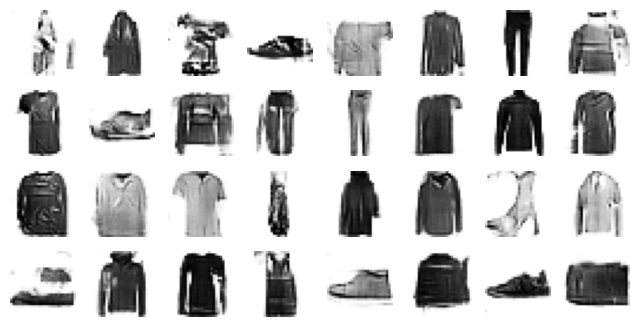

Epoch 39/50


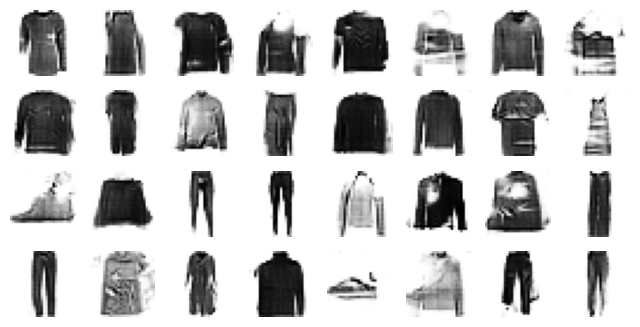

Epoch 40/50


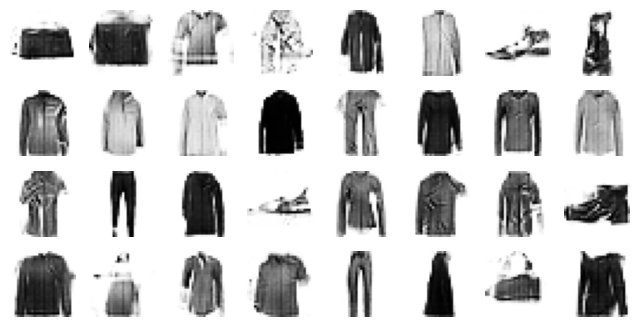

Epoch 41/50


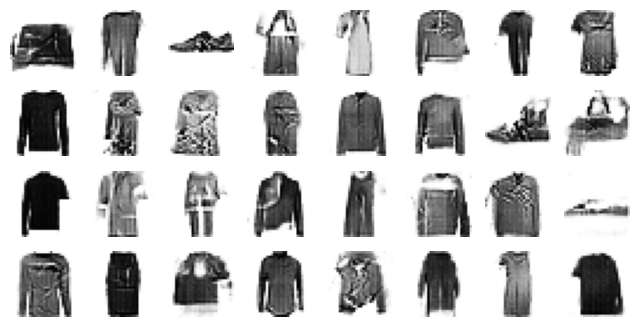

Epoch 42/50


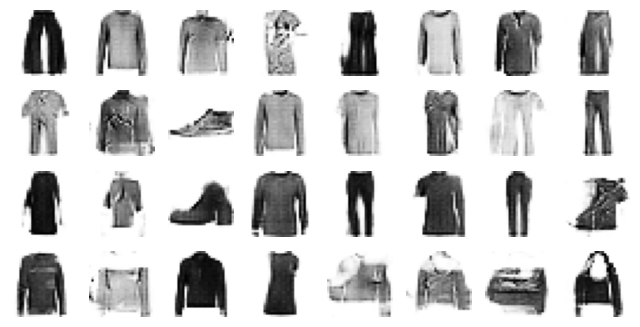

Epoch 43/50


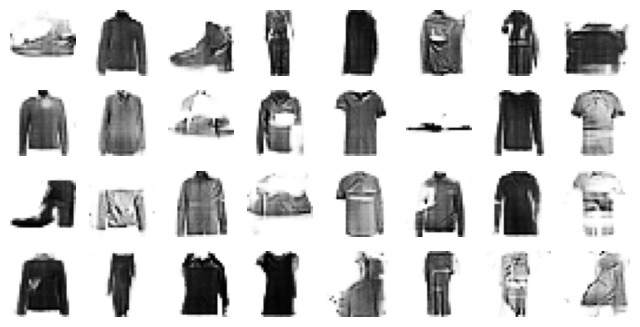

Epoch 44/50


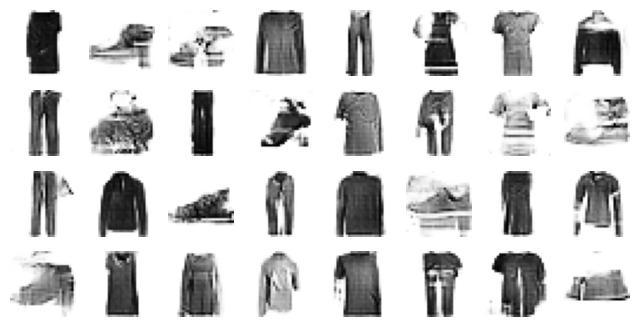

Epoch 45/50


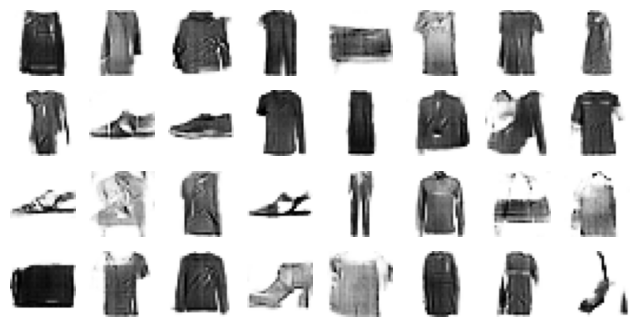

Epoch 46/50


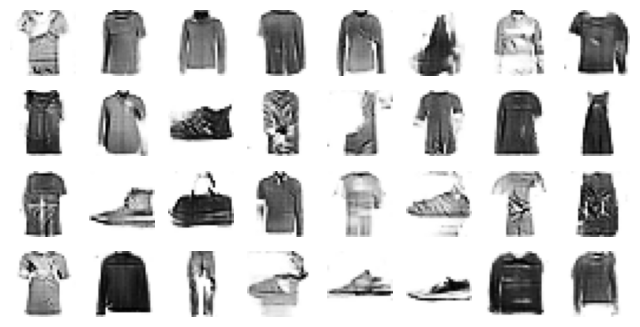

Epoch 47/50


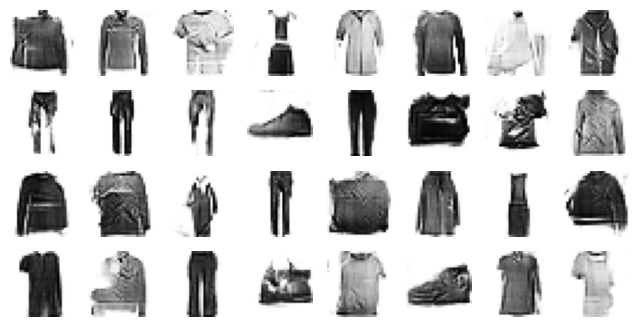

Epoch 48/50


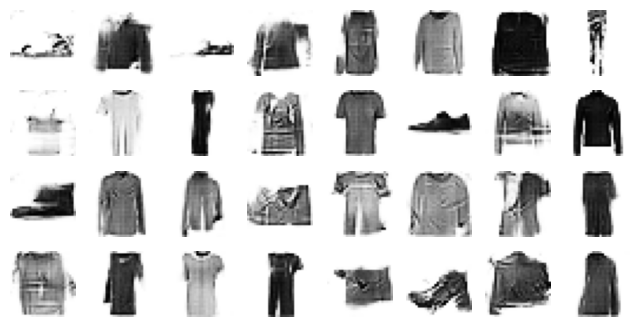

Epoch 49/50


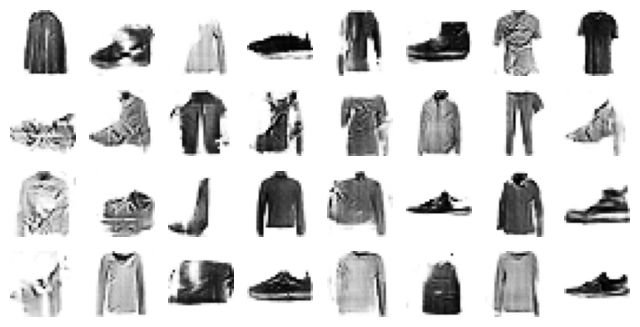

Epoch 50/50


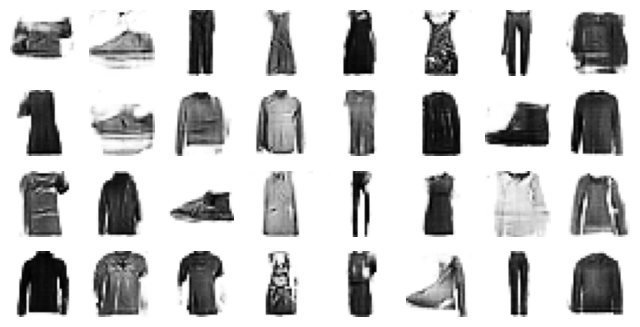

In [14]:
train_gan(gan, dataset, batch_size, codings_size, nr_epochs=50)